In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_binary = r'/mnt/data/psteinmetz/bb_results.csv'
path_to_csv_binary_40 = r'/mnt/data/psteinmetz/bb_results_40.csv'

In [3]:
data_tumor = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_binary = pd.read_csv(path_to_csv_binary).dropna()

data_binary_40 = pd.read_csv(path_to_csv_binary_40).dropna()

In [4]:
data_tum = pd.concat((data_tumor['Record_ID'], data_tumor.filter(regex='original_shape')), axis=1)

In [5]:
data_tumor = data_tum[['Record_ID', 'original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',  'original_shape_Flatness']]
data_tumor_40 = data_tum[['Record_ID', 'original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0',  'original_shape_Flatness_40.0']]

data_binary = data_binary[data_binary.columns.drop(list(data_binary.filter(regex='original_shape')))]
data_binary_40 = data_binary_40[data_binary_40.columns.drop(list(data_binary_40.filter(regex='original_shape')))]

In [6]:
data_train = pd.merge(data_binary, data_tumor, on='Record_ID')
data_train_40 = pd.merge(data_binary_40, data_tumor_40, on='Record_ID')

In [7]:
data_train = data_train[[i for i in data_train if len(set(data_train[i]))>1]]
data_train_40 = data_train_40[[i for i in data_train_40 if len(set(data_train_40[i]))>1]]

In [8]:
data_train[['Shape.1', 'Margins (MR)']].value_counts()

Shape.1    Margins (MR) 
Irregular  Irregular        54
           Spiculated       45
Round      Irregular        12
Oval       Irregular         6
Round      Spiculated        6
Oval       Spiculated        5
Irregular  Circunscribed     1
Oval       Circunscribed     1
Round      Circunscribed     1
Name: count, dtype: int64

In [8]:
X_train = data_train[data_train.columns.drop(['Unnamed: 0', 'Record_ID', 'Shape.1', 'Margins (MR)'])]
y_train = data_train[['Shape.1']]

X_train_40 = data_train_40[data_train_40.columns.drop(['Record_ID', 'Shape.1', 'Margins (MR)'])]

In [9]:
y_train.value_counts()

Shape.1  
Irregular    100
Round         19
Oval          12
Name: count, dtype: int64

In [10]:
X_train

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,...,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZonePercentage,original_shape_Elongation,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,original_shape_Flatness
0,1.0,2.0,48526.0,0.0,2.664961,0.353047,1.228935,1.0,1.0,0.353047,...,8.275978e+08,8.275978e+08,1.208316e-09,1.208316e-09,1.208316e-09,0.000035,0.955938,0.694833,0.372167,0.630005
1,1.0,2.0,51951.0,1.0,1.432758,0.451186,1.343773,1.0,1.0,0.451186,...,6.540806e+08,6.540806e+08,1.528864e-09,1.528864e-09,1.528864e-09,0.000039,0.818758,0.773002,0.303557,0.613126
2,1.0,2.0,228429.0,1.0,2.326044,0.375513,1.250514,1.0,1.0,0.375513,...,1.700833e+10,1.700833e+10,5.879471e-11,5.879471e-11,5.879471e-11,0.000008,0.907496,0.554572,0.273415,0.646003
3,1.0,2.0,138303.0,1.0,2.251180,0.380867,1.255937,1.0,1.0,0.380867,...,6.120559e+09,6.120559e+09,1.633838e-10,1.633838e-10,1.633838e-10,0.000013,0.595196,0.601134,0.296776,0.439169
4,1.0,2.0,43344.0,1.0,2.018536,0.398523,1.274747,1.0,1.0,0.398523,...,5.645376e+08,5.645376e+08,1.771361e-09,1.771361e-09,1.771361e-09,0.000042,0.613325,0.706983,0.366704,0.541888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1.0,2.0,117385.0,0.0,2.368950,0.372512,1.247525,1.0,1.0,0.372512,...,4.537774e+09,4.537774e+09,2.203724e-10,2.203724e-10,2.203724e-10,0.000015,0.680031,0.507956,0.373372,0.527360
127,1.0,2.0,24336.0,1.0,2.270754,0.379452,1.254493,1.0,1.0,0.379452,...,1.904400e+08,1.904400e+08,5.250998e-09,5.250998e-09,5.250998e-09,0.000072,0.682666,0.677886,0.470604,0.610154
128,1.0,2.0,23986.0,0.0,2.659611,0.353381,1.229243,1.0,1.0,0.353381,...,2.019809e+08,2.019809e+08,4.950962e-09,4.950962e-09,4.950962e-09,0.000070,0.849364,0.616137,0.532186,0.598722
129,1.0,2.0,21447.0,0.0,2.371935,0.372305,1.247320,1.0,1.0,0.372305,...,1.515853e+08,1.515853e+08,6.596944e-09,6.596944e-09,6.596944e-09,0.000081,0.775185,0.557357,0.602441,0.546108


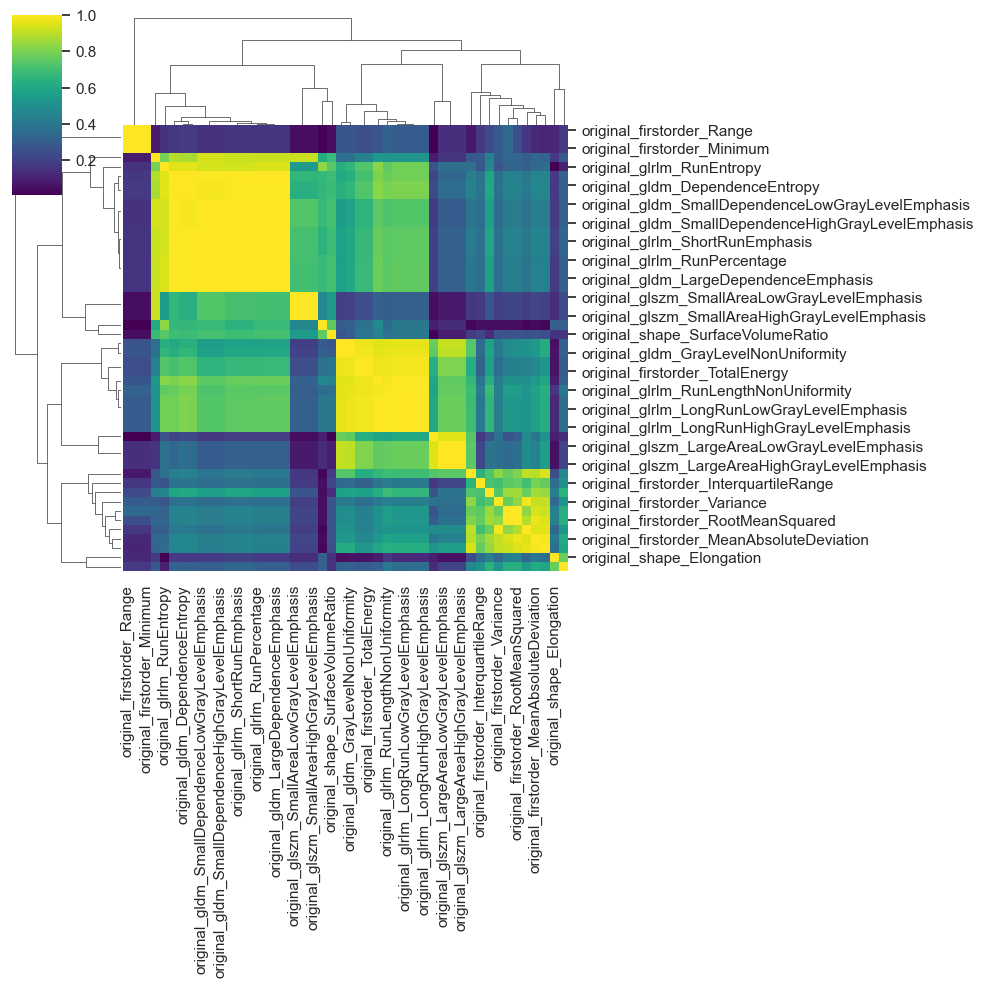

In [13]:
sns.set(rc={'figure.figsize':(15,15)})
sns.clustermap(abs(X_train.corr()), cmap='viridis')

In [14]:
label_encoder = LabelEncoder()
y_train['Shape.1']= label_encoder.fit_transform(y_train['Shape.1']) 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
y_train.value_counts()

Shape.1
0          100
2           19
1           12
Name: count, dtype: int64

In [16]:
y_train.loc[y_train['Shape.1']==2, 'Shape.1'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: xlabel='Shape.1'>

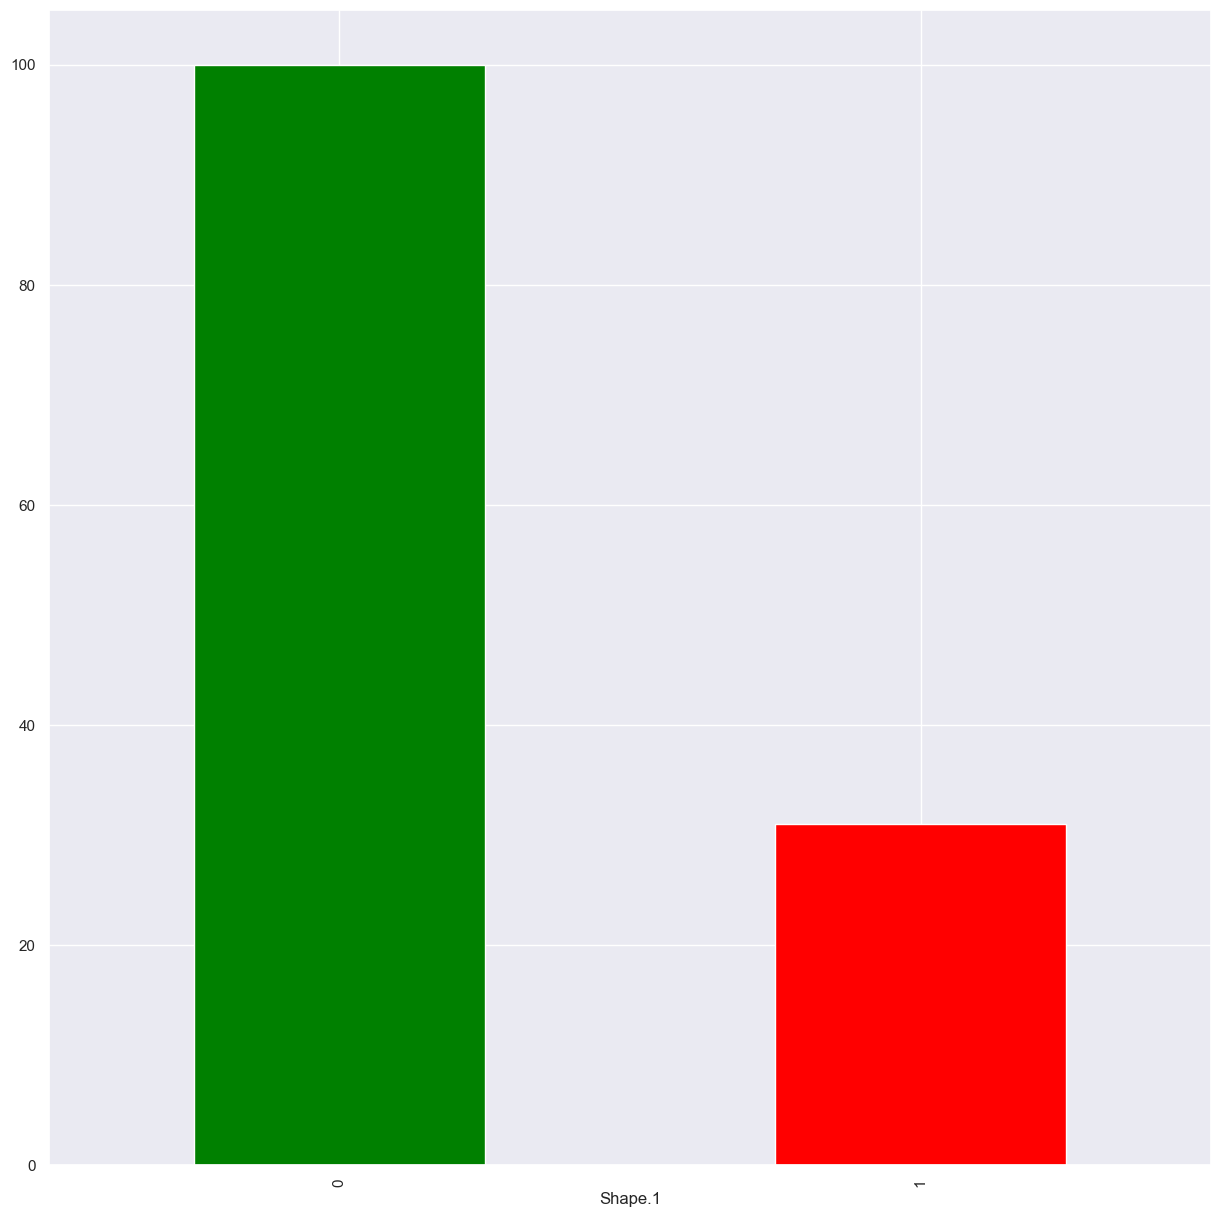

In [17]:
y_train['Shape.1'].value_counts().plot.bar(color=['green', 'red'])

In [18]:
y_train.value_counts()

Shape.1
0          100
1           31
Name: count, dtype: int64

In [19]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

scaler_40 = StandardScaler()
scaled_X_train_40 = pd.DataFrame(scaler_40.fit_transform(X_train_40), columns=X_train_40.columns)

In [20]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [21]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [22]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [23]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': range(2, 20),
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None],
            'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight):

    params_grid = {
        'max_depth': range(2, 20),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    boost_model = XGBClassifier(objective= 'binary:logistic',
                                nthread=4, 
                                scale_pos_weight = sample_weight,
                                random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    if metric == 'youden_index':
        score = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).mean(), 2)
        std = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).std(), 2)
    else:
        score = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean(), 2)
        std = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).std(), 2)

    return score, std

In [24]:
best_params_logreg, grid_search_logreg = grid_search_lr(scaled_X_train, y_train.values.ravel(), skf)
best_params_logreg_40, grid_search_logreg_40 = grid_search_lr(scaled_X_train_40, y_train.values.ravel(), skf)

Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits


In [25]:
grid_search_logreg.best_score_

0.5269591090024527

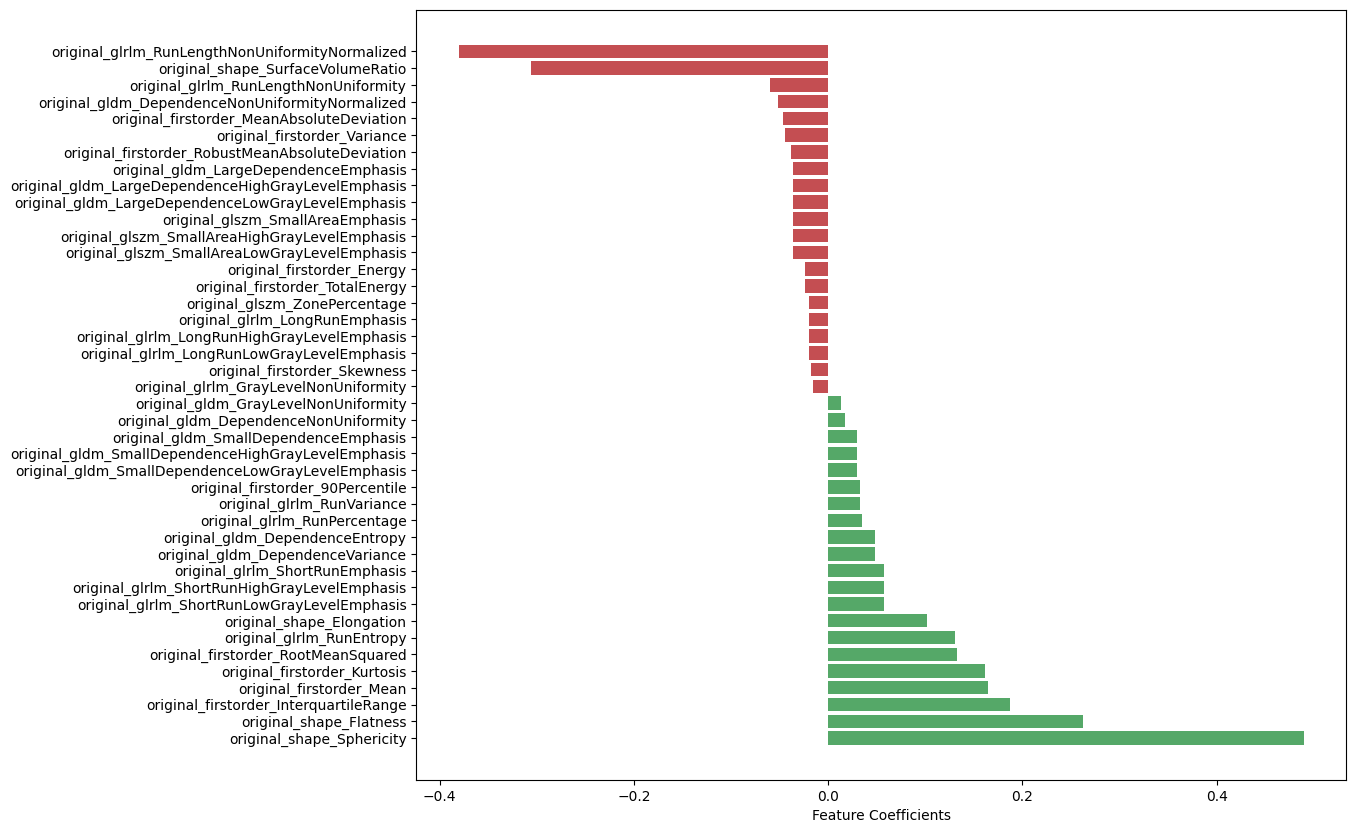

In [26]:
coef_dict = get_feature_coefs(grid_search_logreg.best_estimator_, scaled_X_train)
visualize_coefs(coef_dict)

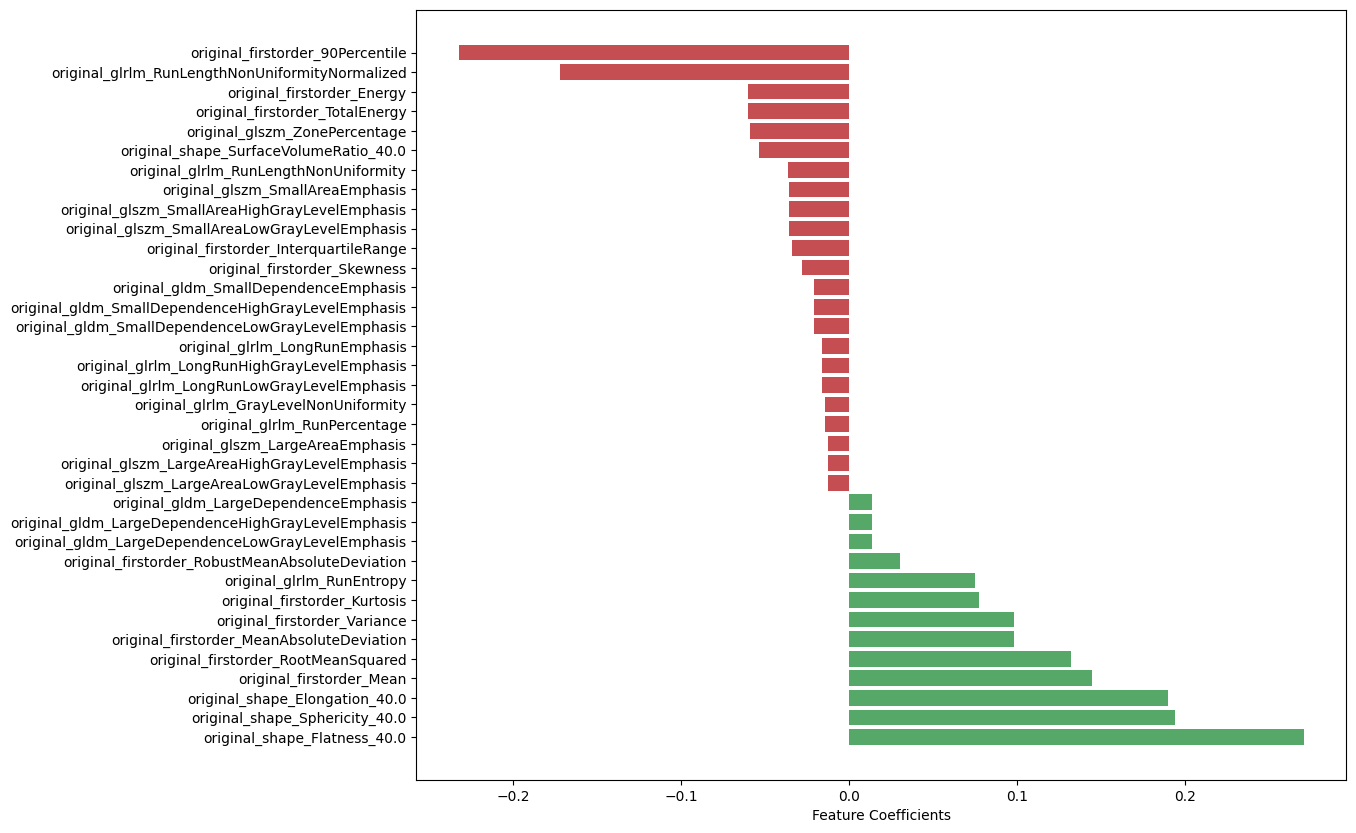

In [27]:
coef_dict = get_feature_coefs(grid_search_logreg_40.best_estimator_, scaled_X_train_40)
visualize_coefs(coef_dict)

In [28]:
background_values_log_reg = shap.maskers.Independent(scaled_X_train, max_samples=100)
# compute SHAP values
explainer_log_reg = shap.Explainer(grid_search_logreg.best_estimator_.predict, background_values_log_reg)
shap_values_log_reg = explainer_log_reg(scaled_X_train)

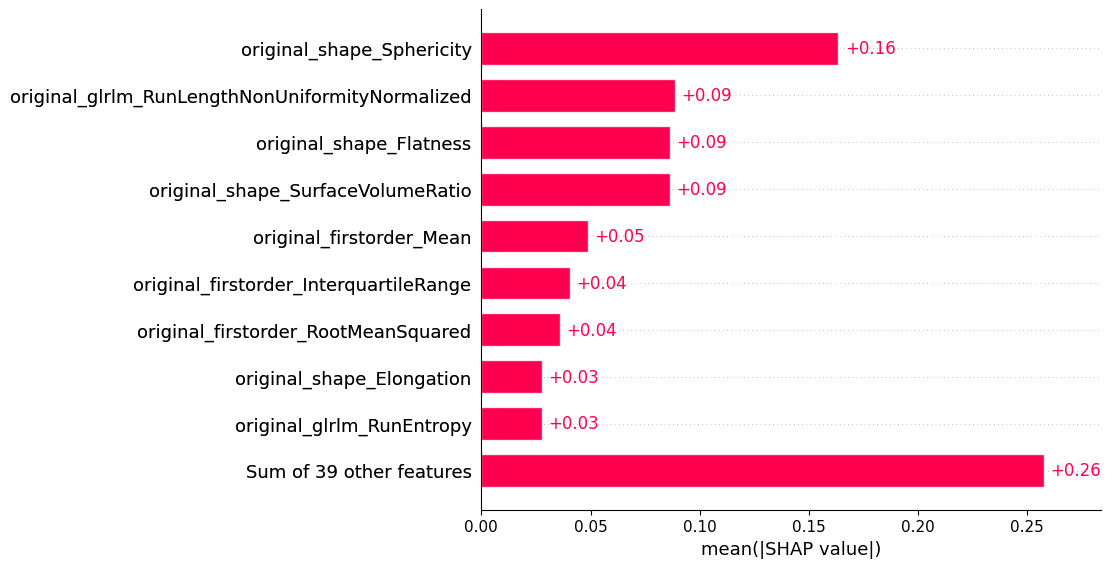

In [29]:
shap.plots.bar(shap_values_log_reg)

In [30]:
background_values_log_reg_40 = shap.maskers.Independent(scaled_X_train_40, max_samples=100)
# compute SHAP values
explainer_log_reg_40 = shap.Explainer(grid_search_logreg_40.best_estimator_.predict, background_values_log_reg_40)
shap_values_log_reg_40 = explainer_log_reg_40(scaled_X_train_40)

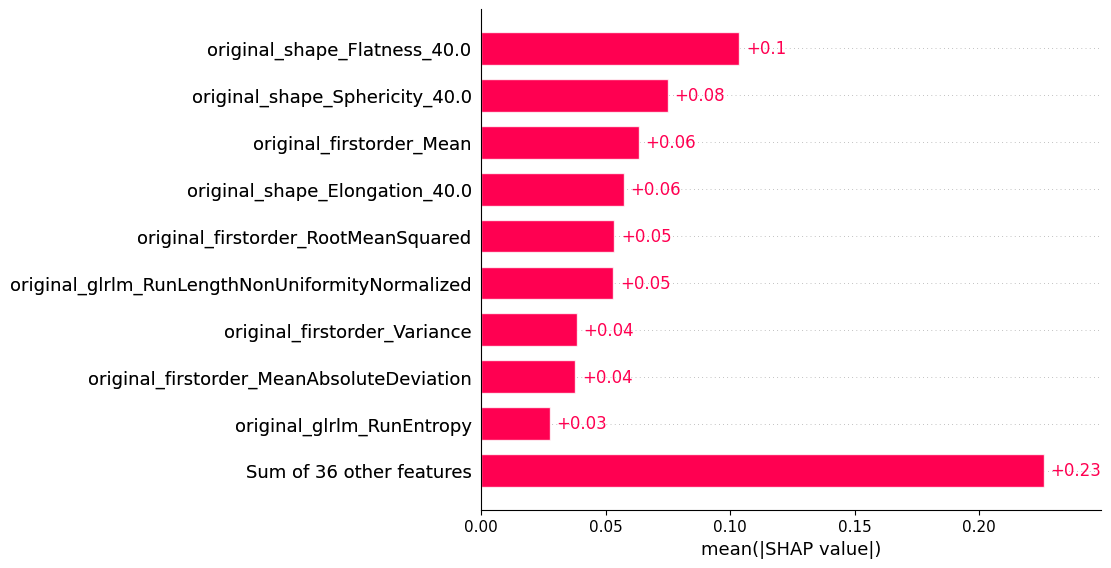

In [31]:
shap.plots.bar(shap_values_log_reg_40)

In [32]:
val_lr = (pd.DataFrame(abs(shap_values_log_reg.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [33]:
val_lr

original_shape_Sphericity                             0.163565
original_glrlm_RunLengthNonUniformityNormalized       0.088504
original_shape_Flatness                               0.086382
original_shape_SurfaceVolumeRatio                     0.086198
original_firstorder_Mean                              0.048878
original_firstorder_InterquartileRange                0.040588
original_firstorder_RootMeanSquared                   0.036061
original_shape_Elongation                             0.027779
original_glrlm_RunEntropy                             0.027679
original_firstorder_Kurtosis                          0.025061
original_glrlm_ShortRunLowGrayLevelEmphasis           0.014496
original_glrlm_ShortRunHighGrayLevelEmphasis          0.014115
original_glrlm_ShortRunEmphasis                       0.014031
original_gldm_DependenceNonUniformityNormalized       0.012947
original_gldm_DependenceVariance                      0.011840
original_firstorder_MeanAbsoluteDeviation             0

In [34]:
val_lr_40 = (pd.DataFrame(abs(shap_values_log_reg_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

In [35]:
val_lr_40

original_shape_Flatness_40.0                          0.103557
original_shape_Sphericity_40.0                        0.075000
original_firstorder_Mean                              0.063328
original_shape_Elongation_40.0                        0.057305
original_firstorder_RootMeanSquared                   0.053420
original_glrlm_RunLengthNonUniformityNormalized       0.053008
original_firstorder_Variance                          0.038382
original_firstorder_MeanAbsoluteDeviation             0.037794
original_glrlm_RunEntropy                             0.027374
original_firstorder_90Percentile                      0.024046
original_firstorder_Kurtosis                          0.021214
original_firstorder_InterquartileRange                0.018115
original_shape_SurfaceVolumeRatio_40.0                0.017519
original_glszm_ZonePercentage                         0.015076
original_firstorder_TotalEnergy                       0.014282
original_firstorder_Energy                            0

In [36]:
best_params_logreg_restricted_nb_of_features, grid_search_logreg_restricted_nb_of_features = grid_search_lr(scaled_X_train[val_lr.keys()[:20]], y_train.values.ravel(), skf)
best_params_logreg_restricted_nb_of_features_40, grid_search_logreg_restricted_nb_of_features_40 = grid_search_lr(scaled_X_train_40[val_lr_40.keys()[:20]], y_train.values.ravel(), skf)

Fitting 5 folds for each of 348 candidates, totalling 1740 fits
Fitting 5 folds for each of 348 candidates, totalling 1740 fits


In [37]:
best_params_rf, grid_search_randomforest = grid_search_rf(X_train, y_train.values.ravel(), skf)
best_params_rf_40, grid_search_randomforest_40 = grid_search_rf(X_train_40, y_train.values.ravel(), skf)

Fitting 5 folds for each of 9450 candidates, totalling 47250 fits


Fitting 5 folds for each of 9450 candidates, totalling 47250 fits


In [39]:
grid_search_randomforest_40.best_score_

0.582684274789538

In [36]:
grid_search_randomforest.best_params_

{'class_weight': {0: 0.2, 1: 0.8},
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 5}

In [40]:
background_values_rf = shap.maskers.Independent(X_train, max_samples=100)
# compute SHAP values
explainer_rf = shap.Explainer(grid_search_randomforest.best_estimator_.predict, background_values_rf)
shap_values_rf = explainer_rf(X_train)

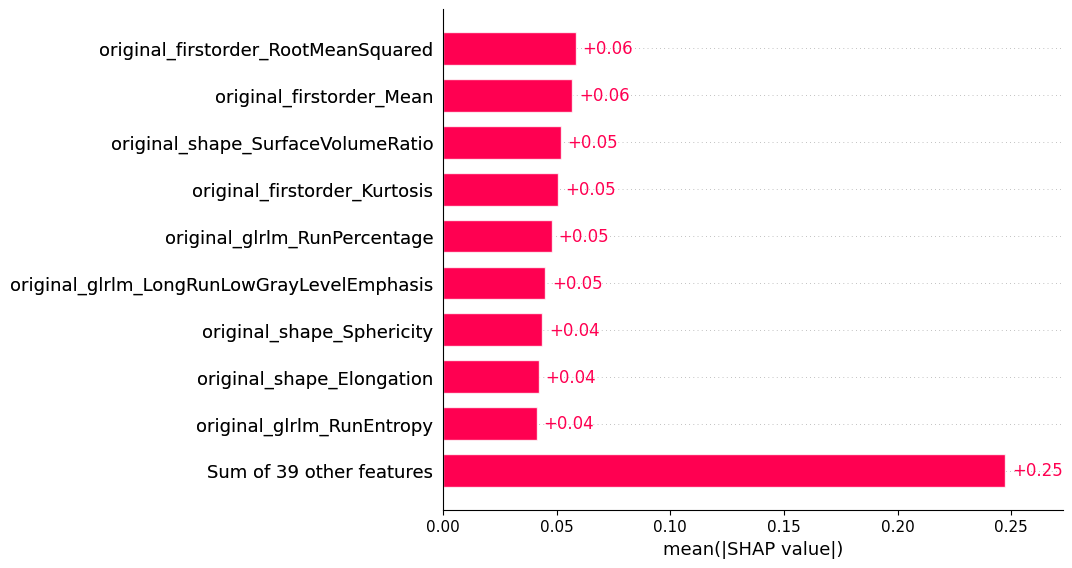

In [41]:
shap.plots.bar(shap_values_rf)

In [42]:
background_values_rf_40 = shap.maskers.Independent(X_train_40, max_samples=100)
# compute SHAP values
explainer_rf_40 = shap.Explainer(grid_search_randomforest_40.best_estimator_.predict, background_values_rf_40)
shap_values_rf_40 = explainer_rf_40(X_train_40)

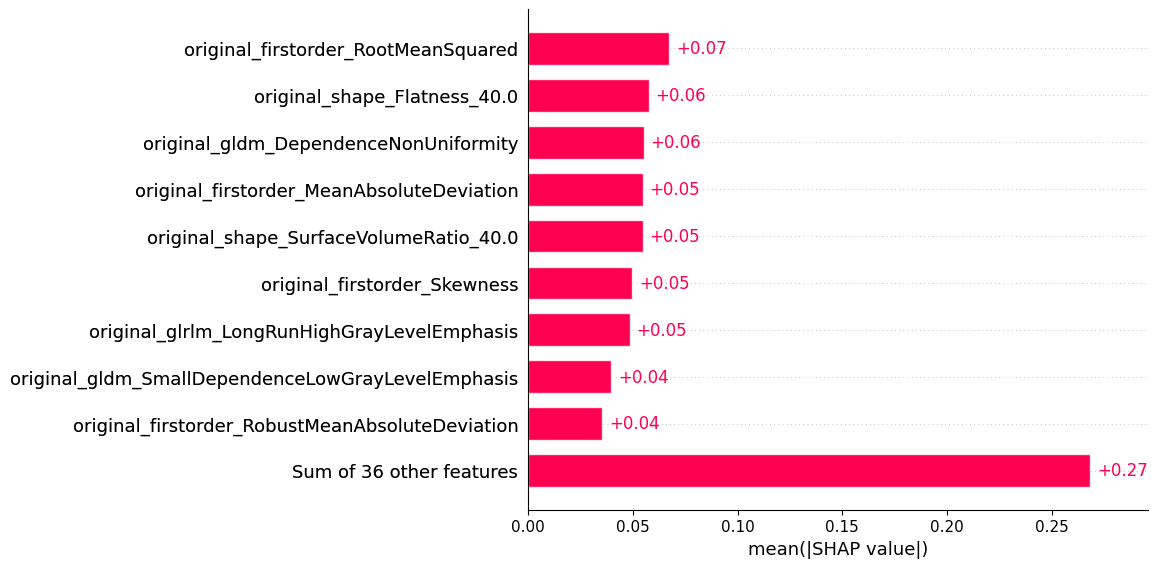

In [43]:
shap.plots.bar(shap_values_rf_40)

In [44]:
val_rf = (pd.DataFrame(abs(shap_values_rf.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [45]:
val_rf[:15]

original_firstorder_RootMeanSquared                  0.058344
original_firstorder_Mean                             0.056969
original_shape_SurfaceVolumeRatio                    0.051786
original_firstorder_Kurtosis                         0.050718
original_glrlm_RunPercentage                         0.047947
original_glrlm_LongRunLowGrayLevelEmphasis           0.045031
original_shape_Sphericity                            0.043664
original_shape_Elongation                            0.042183
original_glrlm_RunEntropy                            0.041221
original_gldm_DependenceVariance                     0.040977
original_gldm_LargeDependenceLowGrayLevelEmphasis    0.038832
original_firstorder_RobustMeanAbsoluteDeviation      0.034939
original_firstorder_Variance                         0.031954
original_glrlm_LongRunEmphasis                       0.027580
original_gldm_DependenceNonUniformityNormalized      0.019855
dtype: float64

Text(0.5, 1.0, 'Visualizing Feature Importances')

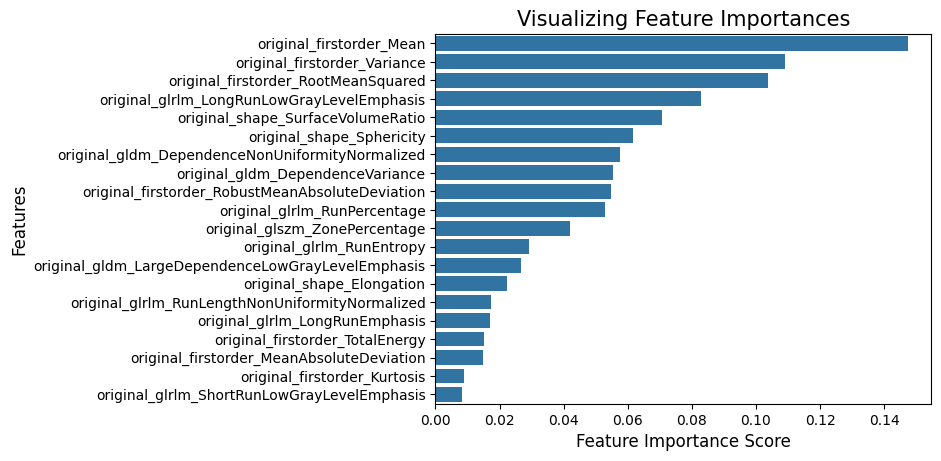

In [46]:
feature_imp = pd.Series(grid_search_randomforest.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [47]:
val_rf_40 = (pd.DataFrame(abs(shap_values_rf_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

Text(0.5, 1.0, 'Visualizing Feature Importances')

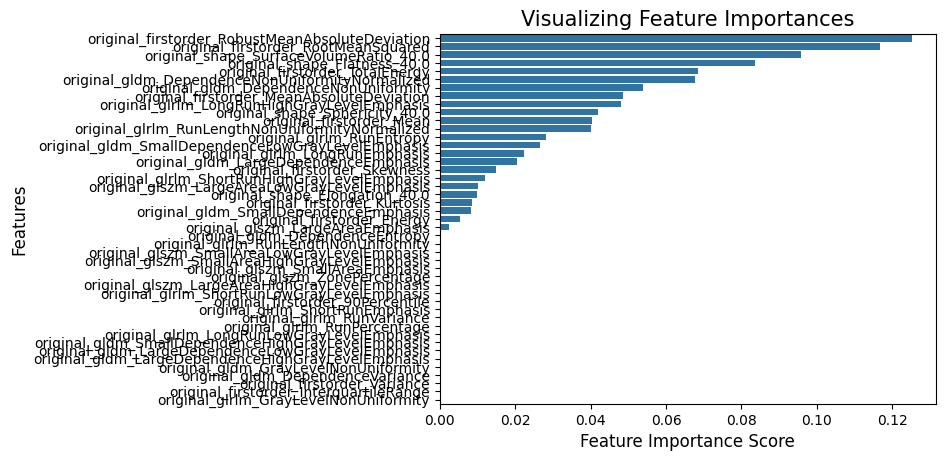

In [48]:
feature_imp_40 = pd.Series(grid_search_randomforest_40.best_estimator_.feature_importances_, index=X_train_40.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_40[:], y=feature_imp_40[:].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [49]:
sum(feature_imp_40[val_rf_40.keys()[:19]])

0.9262210713654602

In [50]:
best_params_rf_restricted_nb_of_features, grid_search_rf_restricted_nb_of_features = grid_search_rf(X_train[val_rf.keys()[:15]], y_train.values.ravel(), skf)
best_params_rf_restricted_nb_of_features_40, grid_search_rf_restricted_nb_of_features_40 = grid_search_rf(X_train_40[val_rf_40.keys()[:19]], y_train.values.ravel(), skf)

Fitting 5 folds for each of 9450 candidates, totalling 47250 fits
Fitting 5 folds for each of 9450 candidates, totalling 47250 fits


In [51]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

In [52]:
best_params_xgb, grid_search_xgboost = grid_search_xgb(X_train, y_train.values.ravel(), skf, ratio)
best_params_xgb_40, grid_search_xgboost_40 = grid_search_xgb(X_train_40, y_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [46]:
grid_search_xgboost.best_score_

0.440934065934066

In [53]:
background_values_xgb = shap.maskers.Independent(X_train, max_samples=100)
# compute SHAP values
explainer_xgb = shap.Explainer(grid_search_xgboost.best_estimator_.predict, background_values_xgb)
shap_values_xgb = explainer_xgb(X_train)

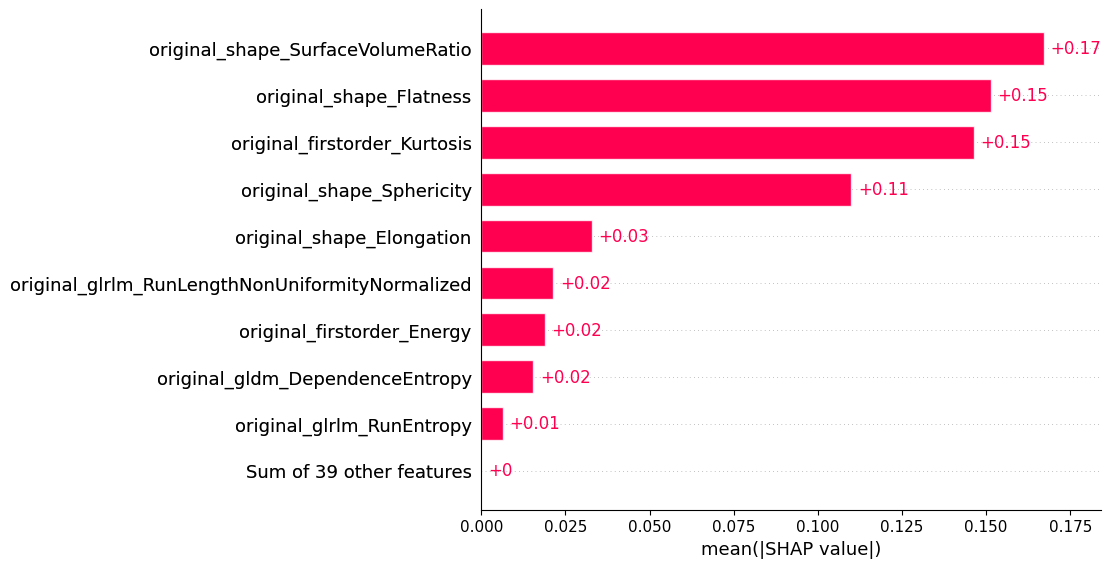

In [54]:
shap.plots.bar(shap_values_xgb)

In [55]:
background_values_xgb_40 = shap.maskers.Independent(X_train_40, max_samples=100)
# compute SHAP values
explainer_xgb_40 = shap.Explainer(grid_search_xgboost_40.best_estimator_.predict, background_values_xgb_40)
shap_values_xgb_40 = explainer_xgb_40(X_train_40)

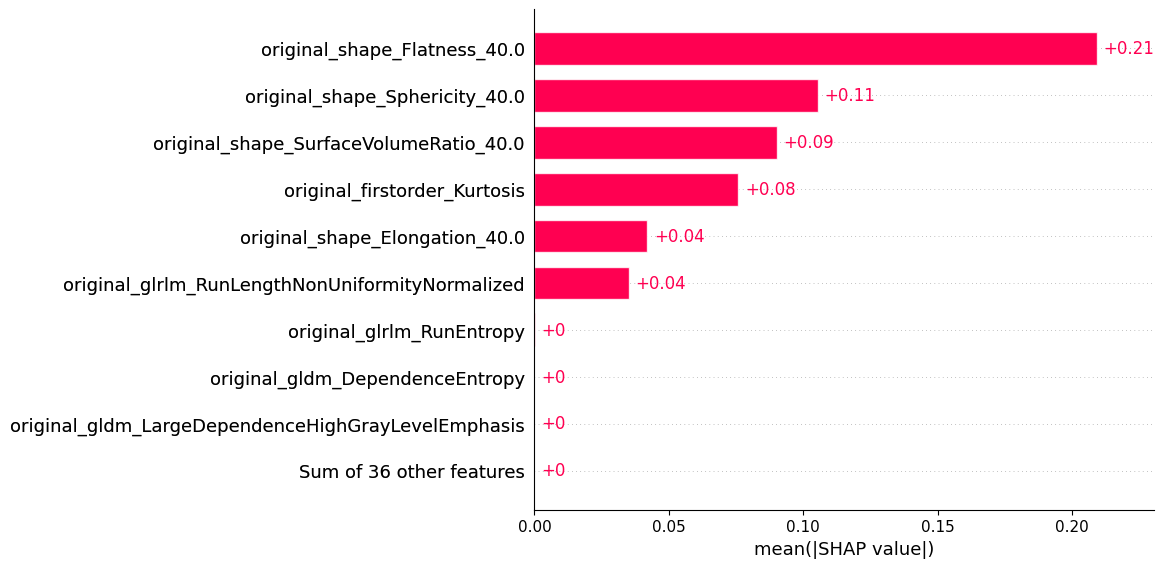

In [56]:
shap.plots.bar(shap_values_xgb_40)

In [57]:
val_xgb = (pd.DataFrame(abs(shap_values_xgb.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [58]:
val_xgb_40 = (pd.DataFrame(abs(shap_values_xgb_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

In [59]:
best_params_xgb_restricted_nb_of_features, grid_search_xgb_restricted_nb_of_features = grid_search_xgb(X_train[val_xgb.keys()[:9]], y_train.values.ravel(), skf, ratio)
best_params_xgb_restricted_nb_of_features_40, grid_search_xgb_restricted_nb_of_features_40 = grid_search_xgb(X_train_40[val_xgb_40.keys()[:5]], y_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [60]:
def compile_results(model, X, y, kfolds, return_bool=None):
    
    auc, auc_std = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy, balanced_accuracy_std = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision, precision_std = return_kfold_score(model, X, y, 'precision', kfolds)
    recall, recall_std = return_kfold_score(model, X, y, 'recall', kfolds)
    f1, f1_std = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity, specificity_std = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity, sensitivity_std = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index , youden_index_std = return_kfold_score(model, X, y, 'youden_index', kfolds, 'youden_index')

    if return_bool is None:
        for x in [('auc', auc, auc_std), ('balanced_acc', balanced_accuracy, balanced_accuracy_std), ('precision', precision, precision_std), ('recall', recall, recall_std), ('f1', f1, f1_std), ('specificity', specificity, specificity_std), ('sensitivity', sensitivity, sensitivity_std), ('youden_index', youden_index, youden_index_std)]:       
            print(str(x[0]) + ' ' + str(str(x[1])) + ' +/- ' + str(x[2]))

    if return_bool:

        return [(auc, auc_std), (balanced_accuracy, balanced_accuracy_std), (precision, precision_std), (recall, recall_std), (f1, f1_std), (specificity, specificity_std), (sensitivity, sensitivity_std), (youden_index, youden_index_std)]

In [61]:
comp_results = [compile_results(x, (scaled_X_train if x==grid_search_logreg.best_estimator_ else X_train), y_train.values.ravel(), skf, True) for x in [grid_search_logreg.best_estimator_, grid_search_randomforest.best_estimator_, grid_search_xgboost.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [62]:
results

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.72, 0.13)","(0.65, 0.14)","(0.67, 0.14)"
balanced_accuracy,"(0.7, 0.1)","(0.7, 0.04)","(0.63, 0.09)"
precision,"(0.39, 0.09)","(0.42, 0.03)","(0.38, 0.11)"
recall,"(0.84, 0.11)","(0.71, 0.1)","(0.55, 0.18)"
f1,"(0.53, 0.11)","(0.52, 0.04)","(0.44, 0.11)"
specificity,"(0.57, 0.1)","(0.69, 0.05)","(0.71, 0.1)"
sensitivity,"(0.84, 0.11)","(0.71, 0.1)","(0.55, 0.18)"
youden_index,"(0.41, 0.2)","(0.4, 0.09)","(0.26, 0.17)"


In [63]:
comp_results_40 = [compile_results(x, (scaled_X_train_40 if x==grid_search_logreg_40.best_estimator_ else X_train_40), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_40.best_estimator_, grid_search_randomforest_40.best_estimator_, grid_search_xgboost_40.best_estimator_]]
results_40 = pd.DataFrame(comp_results_40, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [64]:
results_40

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.73, 0.12)","(0.75, 0.1)","(0.7, 0.13)"
balanced_accuracy,"(0.7, 0.07)","(0.75, 0.09)","(0.63, 0.09)"
precision,"(0.53, 0.16)","(0.46, 0.11)","(0.37, 0.1)"
recall,"(0.61, 0.09)","(0.8, 0.13)","(0.61, 0.14)"
f1,"(0.55, 0.1)","(0.58, 0.11)","(0.46, 0.11)"
specificity,"(0.8, 0.11)","(0.69, 0.12)","(0.66, 0.11)"
sensitivity,"(0.61, 0.09)","(0.8, 0.13)","(0.61, 0.14)"
youden_index,"(0.41, 0.13)","(0.49, 0.19)","(0.27, 0.19)"


In [65]:
comp_results_restricted_nb_of_features = [compile_results(x, (scaled_X_train[val_lr.keys()[:10]] if x==grid_search_logreg_restricted_nb_of_features.best_estimator_ else X_train[val_rf.keys()[:15]] if x==grid_search_rf_restricted_nb_of_features else X_train[val_xgb.keys()[:4]]), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_restricted_nb_of_features.best_estimator_, grid_search_rf_restricted_nb_of_features.best_estimator_, grid_search_xgb_restricted_nb_of_features.best_estimator_]]
results_restricted_nb_of_features = pd.DataFrame(comp_results_restricted_nb_of_features, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [66]:
results_restricted_nb_of_features

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.76, 0.13)","(0.71, 0.09)","(0.69, 0.13)"
balanced_accuracy,"(0.7, 0.09)","(0.65, 0.09)","(0.63, 0.09)"
precision,"(0.49, 0.17)","(0.35, 0.07)","(0.37, 0.09)"
recall,"(0.65, 0.11)","(0.72, 0.16)","(0.55, 0.18)"
f1,"(0.55, 0.13)","(0.47, 0.09)","(0.44, 0.11)"
specificity,"(0.76, 0.12)","(0.59, 0.08)","(0.71, 0.08)"
sensitivity,"(0.65, 0.11)","(0.72, 0.16)","(0.55, 0.18)"
youden_index,"(0.41, 0.19)","(0.31, 0.19)","(0.26, 0.18)"


In [67]:
comp_results_restricted_nb_of_features_40 = [compile_results(x, (scaled_X_train_40[val_lr_40.keys()[:2]] if x==grid_search_logreg_restricted_nb_of_features_40.best_estimator_ else X_train_40[val_rf_40.keys()[:19]] if x==grid_search_rf_restricted_nb_of_features_40 else X_train_40[val_xgb_40.keys()[:9]]), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_restricted_nb_of_features_40.best_estimator_, grid_search_rf_restricted_nb_of_features_40.best_estimator_, grid_search_xgb_restricted_nb_of_features_40.best_estimator_]]
results_restricted_nb_of_features_40 = pd.DataFrame(comp_results_restricted_nb_of_features_40, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [68]:
results_restricted_nb_of_features_40

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.75, 0.06)","(0.7, 0.12)","(0.69, 0.12)"
balanced_accuracy,"(0.66, 0.09)","(0.68, 0.09)","(0.62, 0.1)"
precision,"(0.57, 0.14)","(0.41, 0.11)","(0.35, 0.11)"
recall,"(0.42, 0.17)","(0.68, 0.11)","(0.58, 0.18)"
f1,"(0.47, 0.15)","(0.51, 0.11)","(0.43, 0.13)"
specificity,"(0.9, 0.05)","(0.68, 0.1)","(0.66, 0.11)"
sensitivity,"(0.42, 0.17)","(0.68, 0.11)","(0.58, 0.18)"
youden_index,"(0.32, 0.17)","(0.36, 0.17)","(0.24, 0.2)"
